# 5SSG2060_Practical_7_Voronoi & Spatial Interpolation
<a href="#This Week's Overview">This Week's Overview</a>

<a href="#Learning Outcomes">Learning Outcomes</a>

<a href="#Get prepared">Get prepared</a>
  - <a href='#Import libraries'>Import libraries</a>
  - <a href='#Read the data'>Read the data</a>
  
<a href='#Voronoi diagram'>Voronoi diagram</a>
  - <a href='#Warm up with sample points'>Warm up with sample points</a>
  - <a href='#Work with full dataset'>Work with full dataset</a>
  - <a href='#Trimming by bbox'>Trimming by bbox</a>    
  - <a href='#Voronoi weights'>Voronoi weights</a>
  - <a href='#Voronoi visualization'>Voronoi visualization</a>

<a href='#Delaunay Triangulations'>Delaunay Triangulations</a>
  - <a href='#Coplanar Points'>Coplanar Points<a/>

<a href='#Convex Hulls'>Convex Hulls<a/> (Optional)

<a href='#Interpolation'>Interpolation</a>
- <a href='#Basic Interpolation'>Basic Interpolation</a>
- <a href='#Kriging Interpolation'>Kriging Interpolation</a>
  - <a href='#2D Kriging Calculation'>2D Kriging Calculation</a> 
  - <a href='#2D Kriging Visualization'>2D Kriging Visualization</a> 
      

- <a href="#Task 1">Task 1</a>
- <a href="#Task 2">Task 2</a>
- <a href="#Task 3">Task 3</a>
- <a href="#Task 4">Task 4</a>
- <a href="#Task 5">Task 5</a>
- <a href="#Task 6">Task 6</a>
- <a href="#Task 7">Task 7</a> 
- <a href="#Task 8">Task 8</a>
- <a href="#Task 9">Task 9</a>

## <a id="This Week's Overview">This Week's Overview</a>

For this practical, based on our familiarity with point pattern analysis since last week, we will further explore the distribution of **London tube stations** as point data, and try to simulate the density of **passengers' entries & exits** in 2017 as an example. To realize both goals, we will recall our knowledge from the lecture on drawing voronoi diagram, building up buffers and conducting kriging interpolation. Hence specific packages like `scipy.spatial`, `scipy.interpolate`, `pykrige` will be used to play the functionality. 

## <a id='Learning Outcomes'> Learning Outcomes</a>
We will look at ways to measure distance and proximity (produce buffers), starting with tessellate space (Voronoi diagrams).
By the end of this practical, you should be able to
- Understand the notions of Voronoi diagrams (VDs) and Delaunay tessellations (DTs).
- Generate VDs and DTs.
- Enhance your understanding of the definition and role of a convex hull.

## <a id='Get prepared'> Get prepared</a> 
### <span style="color:red;">Important Note for Using Your Own Laptop</span>
We will use `pykrige` and `smopy` for interpolation and visualization purposes respectively, please pip install the two packages under our `gsa2018` environment:

$ **pip install pykrige**

$ **pip install smopy**

### <a id='Import libraries'> Import libraries</a>

In [2]:
# general requirements
import sys
import urllib
import zipfile
import os
sys.path.append(os.path.abspath('..'))
import libpysal
from libpysal.cg.voronoi import voronoi, voronoi_frames
import numpy as np
import pandas as pd
import scipy.spatial as spatial
%matplotlib inline
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

# voronoi weights
from libpysal.weights.contiguity import Voronoi as Vornoi_weights
# voronoi plot
from scipy.spatial import Voronoi, voronoi_plot_2d
# voronoi streetmap visualization
import smopy

# spatial delaunay and visualization
from scipy.spatial import Delaunay, delaunay_plot_2d
import matplotlib.tri as mpltri
import math
# convex hull and visualization
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import shapely
from shapely.geometry.polygon import Polygon

# interpolation and kriging interpolation
import glob
from pykrige.ok import OrdinaryKriging
from pykrige.kriging_tools import write_asc_grid
import pykrige.kriging_tools as kt

import scipy.optimize
import scipy.interpolate
 
import random
import folium
import branca.colormap as cm
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Path, PathPatch

# ignore warnings message presence
import warnings
warnings.simplefilter('ignore')

### <a id='Read the data'> Read the data</a>

This week, we are expected to realize 2 main tasks: Voronoi diagram visualization, and spatial interpolation, using London stations and entries & exits datasets. Please copy your london stations data (.csv) used last week into your "data" folder, and add the entries&exits.csv data by the following section:

In [3]:
# Create the data dir if it doesn't exist
if os.path.isdir('data') is not True:
    print("Creating 'data' directory...")
    os.mkdir('data')

# Configure the download
url  = 'https://github.com/cusp-london/Spatial-Data-Analysis/blob/master/annual_station_entry_and_exit_figures.csv?raw=true'
path = os.path.join("data","annual_station_entry_and_exit_figures.csv")

# Download
r    = urllib.request.urlretrieve(url, path)

In [4]:
stations=pd.read_csv('data/london-stations.csv')

## <a id='Voronoi diagram'> Voronoi diagram</a> 

You had already been introduced the [Voronoi diagram](https://en.wikipedia.org/wiki/Voronoi_diagram#Formal_definition) this week, wich partitions set of points into regions based on distances. Within the set of points, or so-called seeds, each one will have its corresponding region with all points closer than others, and these regions are Voronoi cells (or polygons) due to their similar shape to cell. You may also explore the definition of its [Delaunay triangulation](http://mathworld.wolfram.com/DelaunayTriangulation.html). The definition of [distance metric space](https://en.wikipedia.org/wiki/Metric_space) is crucial to Voronoi diagram. 

Voronoi diagrams have practical applications in many fields, i.e. in mesh generation, point location, cluster analysis, machining plans. For example, the Vornonoi diagram for a point locational dataset can help to make nearest neighbor queries, e.g. the nearest hospital near a community; to find the largest empty circle amid a set of points, and in an enclosing polygon, e.g. to build a new supermarket as far as possible from all the existing ones in a city.

### <a id='Warm up with sample points'> Warm up with sample points</a>  
We are going to learn the basis of Voronoi by using `PySAL` as the starting point. We use the 10 sample station coordinates as example to get you familiar with the elementary features in Voronoi, i.e. regions and vertices.

In [5]:
# view information for 10 sample stations
stations.head(10)  # your code here

,id,latitude,longitude,name,display_name,zone,total_lines,rail
0,1,51.5028,-0.2801,Acton Town,Acton<br />Town,3.0,2,0
1,2,51.5143,-0.0755,Aldgate,NaN,1.0,2,0
2,3,51.5154,-0.0726,Aldgate East,Aldgate<br />East,1.0,2,0
3,4,51.5107,-0.0130,All Saints,All<br />Saints,2.0,1,0
4,5,51.5407,-0.2997,Alperton,NaN,4.0,1,0
5,7,51.5322,-0.1058,Angel,NaN,1.0,1,0
6,8,51.5653,-0.1353,Archway,NaN,2.5,1,0
7,9,51.6164,-0.1331,Arnos Grove,Arnos<br />Grove,4.0,1,0
8,10,51.5586,-0.1059,Arsenal,NaN,2.0,1,0
9,11,51.5226,-0.1571,Baker Street,Baker<br />Street,1.0,5,0


Upon calling `voronoi` function, you will get features like `regions` and `vertices`. Check the data type and discuss with your neighours about your observation: what do you think they refer to? what is the meaning? how to interpret the outputs you got?

In [6]:
pts_sample = [(-0.2801, 51.5028), (-0.0755, 51.5143), (-0.0726, 51.5154), (-0.0130, 51.5107), (-0.2997, 51.5407), 
          (-0.1058, 51.5322), (-0.1353, 51.5653), (-0.1331, 51.6164), (-0.1059, 51.5586), (-0.1571, 51.5226)]
regions_sample, vertices_sample = voronoi(pts_sample)
regions_sample

[[15, 14, 2, 3, 1],
 [13, 8, 2, 3, 9],
 [13, 8, 7, 12],
 [16, 17, 0, 7, 8, 2],
 [18, 1, 6, 5, 19],
 [13, 9, 10, 11, 12],
 [11, 4, 5, 6, 10],
 [5, 4, 0, 21, 20],
 [12, 7, 0, 4, 11],
 [10, 6, 1, 3, 9]]

In [7]:
vertices_sample

array([[-4.23144386e-03,  5.16417440e+01],
       [-2.25424338e-01,  5.15550936e+01],
       [-1.11954556e-01,  5.03370737e+01],
       [-1.56269591e-01,  5.11254959e+01],
       [-1.14210074e-01,  5.15899894e+01],
       [-2.23740525e-01,  5.15947050e+01],
       [-2.21931252e-01,  5.15826137e+01],
       [-3.77827776e-02,  5.15766727e+01],
       [-4.80611630e-02,  5.14463340e+01],
       [-1.21045137e-01,  5.14717990e+01],
       [-1.33316162e-01,  5.15373723e+01],
       [-1.24387601e-01,  5.15453298e+01],
       [-7.82169136e-02,  5.15455047e+01],
       [-8.24811825e-02,  5.15370777e+01],
       [ 2.95774155e+00, -5.34497401e+01],
       [-9.24544403e+01,  3.85882151e+00],
       [ 2.95774155e+00, -5.34497401e+01],
       [ 6.85946052e+01,  1.29586118e+02],
       [-9.24544403e+01,  3.85882151e+00],
       [-4.31769851e+01,  1.46125888e+02],
       [-4.31769851e+01,  1.46125888e+02],
       [ 6.85946052e+01,  1.29586118e+02]])

In [8]:
# read the features into dataframes for further use
region_sample_df, pts_sample_df = voronoi_frames(pts_sample)

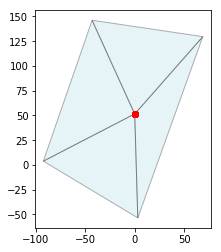

In [9]:
# get the sample frame and point plotted
fig, ax = plt.subplots()
region_sample_df.plot(ax=ax, color='lightblue',edgecolor='black', alpha=0.3)
pts_sample_df.plot(ax=ax, color='red')

### <a id='Work with full dataset'> Work with full dataset</a> 
Happy with the sample test so far? Now let's try to explore the full dataset. We need to start with defining the points, right? However, what type of points data are you expecting?

In [10]:
# points should be array
# google function 'vstack' from numpy
points = np.vstack([stations['longitude'], stations['latitude']]).T 
# call voronoi function
results = voronoi(points)
# define minimum and maximum locations of the points
mins = points.min(axis=0)
maxs = points.max(axis=0)

### <a id="Task 1">Task 1</a>
Follow the example given with sample data, and get the full stations data plotted:

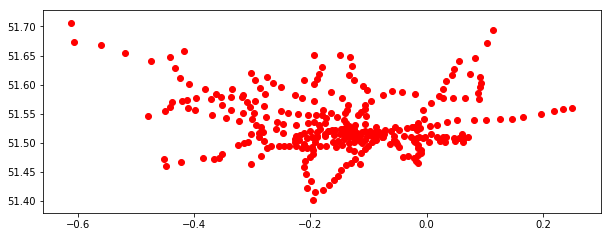

In [11]:
# your codes below
# call voronoi for full dataset
regions, vertices = voronoi(points)
# write into dataframes
regions_df, points_df = voronoi_frames(points)
# plot the points
fig, ax = plt.subplots(figsize=(10,8))
points_df.plot(ax=ax, color='red')

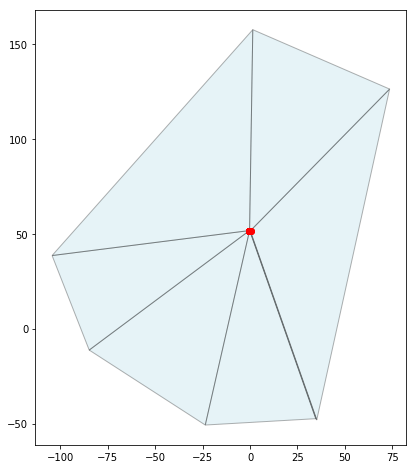

In [12]:
# plot the voronoi frames 
fig, ax = plt.subplots(figsize=(10,8))
regions_df.plot(ax=ax, color='lightblue',edgecolor='black', alpha=0.3)
points_df.plot(ax=ax, color='red')

### <a id='Trimming by bbox'> Trimming by bbox</a> 
This bbox has the similar 'function' as a rectangle window, so it could be used as clipper to 'cut' the points.

In [13]:
# define a bounding box as clipper
# call the minimum and maximum locational data for points
xr = maxs[0] - mins[0]
yr = maxs[1] - mins[1]
# define a buffer area
buff = 0.05
r = max(yr, xr) * buff
minx = mins[0] - r
miny = mins[1] - r
maxx = maxs[0] + r
maxy = maxs[1] + r

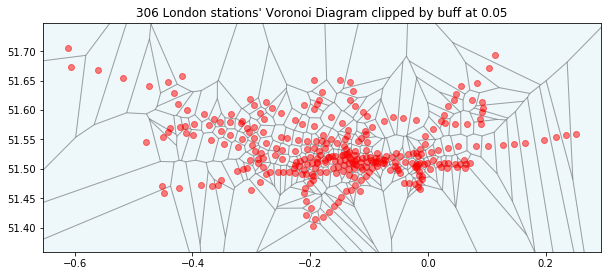

In [14]:
fig, ax = plt.subplots(figsize=(10,8))
regions_df.plot(ax=ax, edgecolor='black', facecolor='lightblue', alpha=0.2 )
points_df.plot(ax=ax, color='red', alpha=0.5 )
plt.xlim(minx, maxx)
plt.ylim(miny, maxy)
plt.title("306 London stations' Voronoi Diagram clipped by buff at 0.05")
plt.show()

### <a id='Voronoi weights'> Voronoi weights</a> 
If we want to get detailed information from `voronoi diagram`, we need call `vornoi weights` function, to get the matrix of vornoi weights. The $number of units$ should be equal to the number of points.

In [15]:
w = Vornoi_weights(points)
w.n

306

However, there might be some weights with value at 0, so in order to get the number of nonzero weights, we can call `nonzero`; to measure the percentage of nonzero weights, we can call `pct_nonzero`. More interpretation of the outputs could be found from [here](https://media.readthedocs.org/pdf/libpysal/latest/libpysal.pdf). Please discuss with your neighbors, why the number of weights is larger than number of points? What is the difference between units and weights?

In [16]:
w.nonzero

1816

In [17]:
w.pct_nonzero

1.939425007475757

If we want to know further which units are defined as neighbors for target observation, we can simply try to call `neighbors`; and the frequency statistics for neighbors could be achieved by calling `histogram`. Could you try to interpret the output by yourself then?

In [18]:
w.neighbors

{0: [90, 122, 43, 58, 203, 252, 158],
 1: [2, 229, 230, 199, 136],
 2: [1, 196, 261, 229, 199],
 3: [32, 64, 55, 24, 175],
 4: [215, 57, 170, 247, 221, 94],
 5: [34, 163, 40, 75, 104, 12, 126],
 6: [105, 34, 231, 233, 269, 109, 78],
 7: [281, 105, 282, 284, 28, 62],
 8: [104, 139, 109, 78],
 9: [185, 39, 25, 141, 142],
 10: [225, 46, 270],
 11: [145, 146, 37, 136, 140],
 12: [146, 163, 5, 75, 219],
 13: [80, 81, 17, 152, 236, 63],
 14: [152, 81, 74],
 15: [178, 259, 119, 169, 92],
 16: [162, 130, 181, 167, 190],
 17: [80, 18, 13, 52, 189, 63],
 18: [17, 305, 52, 189, 303],
 19: [80, 54, 152, 74, 236],
 20: [39, 120, 105, 231, 93, 62, 223],
 21: [195, 228, 261, 213, 199, 23, 143],
 22: [224, 291, 40, 26, 75, 140, 219],
 23: [288, 289, 228, 133, 267, 143, 241, 21, 283],
 24: [64, 50, 3, 294, 175],
 25: [89, 114, 166, 185, 141, 9],
 26: [272, 291, 37, 69, 22, 137, 140],
 27: [164, 88, 153, 186, 170],
 28: [105, 284, 269, 7],
 29: [32, 290, 30, 55],
 30: [290, 55, 250, 29, 143],
 31: [144,

In [19]:
w.histogram

[(3, 6),
 (4, 31),
 (5, 92),
 (6, 87),
 (7, 54),
 (8, 21),
 (9, 11),
 (10, 1),
 (11, 0),
 (12, 2),
 (13, 1)]

From the above result, we can tell the minimum number of neighbors is 3, and the maximum neighbors are 13; the most frequent number of neighbors is 5, which occured 92 times, but there is no observation with 11 neighbors. Try to add the frequencies together, you will find the total number is 306.

As you may find there are 2 observations both have 12 neighbors, so if we want to locate where they exactly are, we can call `cardinalities` to get their coordinates as below.

In [20]:
# cardinalities is the number of neighbors for each observation
id_12 = [i for i in range(w.n) if w.cardinalities[i]==12]
points[id_12]

array([[-0.1145, 51.4627],
       [-0.0637, 51.4979]])

### <a id="Voronoi visualization">Voronoi visualization<a/>
Once you are familiar with the features of Voronoi and Voronoi weights, let's start to use `scipy.spatial` package to practice your capability in computing Voronoi Diagrams, Delaunay Triangulations and Convex Hulls of points, by leveraging the [Qhull library](http://www.qhull.org/). It also links to what we've practiced last week on KDTree implementations for nearest neighbor point queries, as well as distance computations in various metrics. The visualization of results will still mainly rely on `matplotlib.pyplot`, but we will step further by using `Smopy`.

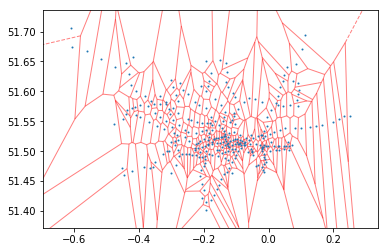

In [21]:
# load geo-locational variables of London stations
points = np.vstack([stations['longitude'], stations['latitude']]).T # points should be array  replace ?????
# plot voronoi diagram by using matplotlib
vor = Voronoi(points)
fig = voronoi_plot_2d(vor, show_vertices=False, line_colors='red', line_width=1, line_alpha=0.5, point_size=2)
plt.show()

We chose to not show vertices for the above plot, trying to avoid mixing up the points and vertices, but you are encourged to make them visible for your research purpose by simply defining show_vertices as "True". Try it and see what is the difference.

As vertices is crucial element in building up a voronoi diagram, we want to read the values for vertices by calling: 

In [22]:
vor.vertices # locational information on nodes equidistant to three (or more) sites

array([[ 3.28624486e-01,  5.09630415e+01],
       [ 2.47567344e-02,  5.14637544e+01],
       [ 4.33257773e-01,  5.06173845e+01],
       ...,
       [-1.32463984e-01,  5.15430851e+01],
       [-1.51917628e-01,  5.15331526e+01],
       [-1.46844560e-01,  5.15318682e+01]])

In [23]:
vor.regions # indices for each voronoi polygon

[[],
 [16, 14, 13, 15],
 [21, 12, 11, 17],
 [20, 16, 15, -1, 6, 19],
 [21, 12, 10, 14, 16, 20],
 [50, 46, 42, 49],
 [51, 47, 48, 46, 50],
 [63, 58, 57, 59, 60, 61, 62],
 [74, 26, 72],
 [74, 26, -1, 2, 0, 73],
 [86, 29, 8, 9, 85],
 [96, 4, 95],
 [102, 13, 15, -1, 101],
 [104, 94, 92, 32, 33, 103],
 [110, 108, 107, 109],
 [109, 91, 93, 18, 35, 107],
 [121, 119, 118, 120],
 [119, 39, 83, 84, 54, 56, 118],
 [120, 61, 62, 55, 56, 118],
 [121, 23, 22, 60, 61, 120],
 [126, 123, 122, 124, 125],
 [123, 40, 36, 35, 18, 19, 6, 7, 122],
 [124, 23, 22, 5, 7, 122],
 [125, 39, 119, 121, 23, 124],
 [130, 70, 71, 69, 68, 128],
 [139, 48, 47, 3, 44, 138],
 [142, 53, 52, 45, 141],
 [149, 144, 145, 146, 147, 148],
 [149, 136, 137, 144],
 [146, 51, 50, 49, 145],
 [149, 136, 135, 24, 133, 134, 41, 148],
 [153, 25, 63, 58, 152],
 [157, 55, 62, 63, 25, 156],
 [161, 66, 67, 65, 159],
 [163, 70, 130, 131, 81, 80, 162],
 [168, 166, 165, 167],
 [166, 79, 27, 78, 76, 165],
 [168, 81, 80, 79, 166],
 [168, 81, 131, 

In [24]:
vor.ridge_points # indices of paired points between which each Voronoi ridge lies

array([[274, 238],
       [274, 271],
       [274, 275],
       ...,
       [120, 149],
       [ 39, 185],
       [149, 185]], dtype=int32)

`Smopy` is another library helps to call the **open street map** for 'real-life' visualization, but not as interactive as `folium`. Let us have a look of the original stations point data.

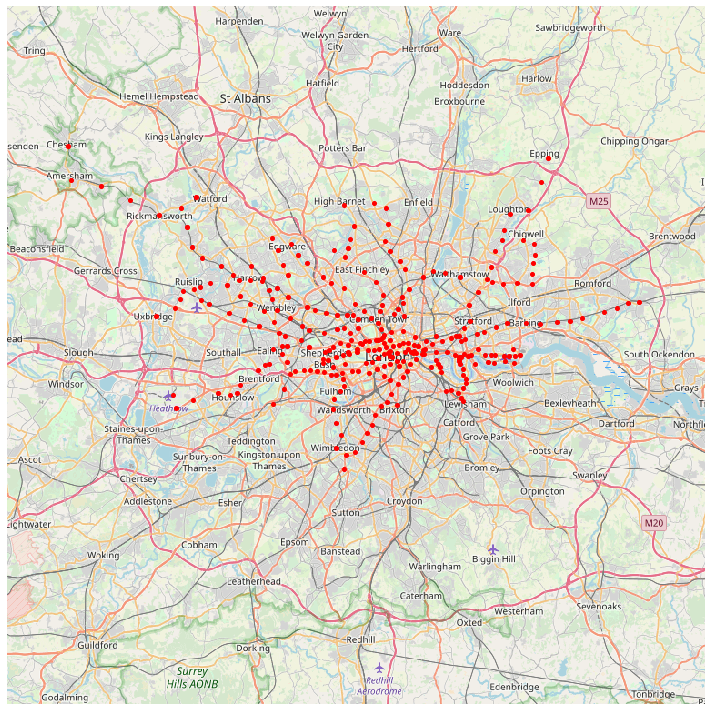

In [25]:
box_stations = (stations.latitude.min(), stations.longitude.min(),
       stations.latitude.max(), stations.longitude.max())
map = smopy.Map(box_stations, z=10) # z is the zoom level, here we set it as 10, you may want to try another value.
# map.show_ipython()
x, y = map.to_pixels(stations.latitude, stations.longitude)
ax = map.show_mpl(figsize=(12, 10))
ax.plot(x, y, 'or', ms=4, mew=1) # 'or' means red dots/circles

Next step is to set up our voronoi function for 2 dimensional points data as 'voronoi_finite_polygons_2d'.

In [26]:
# set up the voronoi function for our finite dataset

vor = Voronoi(np.c_[stations.latitude, stations.longitude])

def voronoi_finite_polygons_2d(vor, radius=None):
    """Reconstruct infinite Voronoi regions in a
    2D diagram to finite regions.
    """
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()
    # Construct a map containing all ridges for a
    # given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points,
                                  vor.ridge_vertices):
        all_ridges.setdefault(
            p1, []).append((p2, v1, v2))
        all_ridges.setdefault(
            p2, []).append((p1, v1, v2))
    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue
        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]
        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue
            # Compute the missing endpoint of an
            # infinite ridge
            t = vor.points[p2] - \
                vor.points[p1]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal
            midpoint = vor.points[[p1, p2]]. \
                mean(axis=0)
            direction = np.sign(
                np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + \
                direction * radius
            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())
        # Sort region counterclockwise.
        vs = np.asarray([new_vertices[v]
                         for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(
            vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[
            np.argsort(angles)]
        new_regions.append(new_region.tolist())
    return new_regions, np.asarray(new_vertices)

In [27]:
regions, vertices = voronoi_finite_polygons_2d(vor)   # call function

Get the results visualized as below:

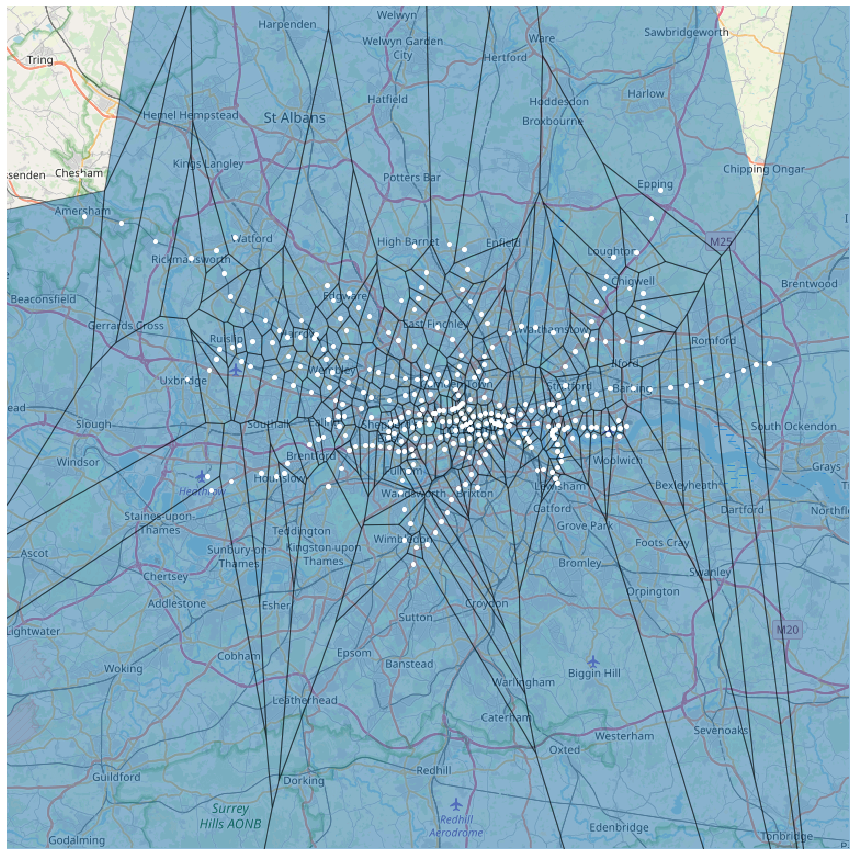

In [28]:
vor_stations = [map.to_pixels(vertices[region])
         for region in regions]  
ax = map.show_mpl(figsize=(12, 15)) # basemap definition
x, y = map.to_pixels(stations.latitude, stations.longitude) # plot the station points
ax.plot(x, y, 'ow', ms=4, mew=1) # white color and shape for points
ax.add_collection(mpl.collections.PolyCollection(vor_stations, edgecolors='k', alpha=.5)) # plot the voronoi

### <a id="Task 2">Task 2<a/>
Let's colorize Voronoi by defined bound, it will help to highlight voronoi differences by colors.

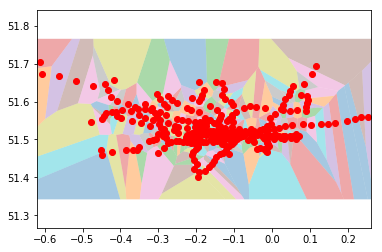

In [29]:
# compute Voronoi tesselation
vor = Voronoi(points)
#  ??????
# plot
regions, vertices = voronoi_finite_polygons_2d(vor)
#  ?????
min_x = vor.min_bound[0] - 0.06
max_x = vor.max_bound[0] + 0.06
min_y = vor.min_bound[1] - 0.06
max_y = vor.max_bound[1] + 0.06

mins = np.tile((min_x, min_y), (vertices.shape[0], 1))
bounded_vertices = np.max((vertices, mins), axis=0)
maxs = np.tile((max_x, max_y), (vertices.shape[0], 1))
bounded_vertices = np.min((bounded_vertices, maxs), axis=0)

bbox = Polygon([[min_x, min_y], [min_x, max_y], [max_x, max_y], [max_x, min_y]])

# colorize
for region in regions:
    polygon = vertices[region]
    # Clipping polygon
    poly = Polygon(polygon)
    poly = poly.intersection(bbox) # ????
    polygon = [p for p in poly.exterior.coords]

    plt.fill(*zip(*polygon), alpha=0.4)

plt.plot(points[:, 0], points[:, 1], 'ro')
plt.axis('equal')
plt.xlim(vor.min_bound[0] - 0.01, vor.max_bound[0] + 0.01)
plt.ylim(vor.min_bound[1] - 0.01, vor.max_bound[1] + 0.01)

plt.show()
# if invisible, plt.savefig(a.png)

## <a id='Delaunay Triangulations'>Delaunay Triangulations</a> 

A [Delaunay Triangulations](http://mathworld.wolfram.com/DelaunayTriangulation.html) or [Delone Triangulations](https://en.wikipedia.org/wiki/Delaunay_triangulation) for a given set $P$ of discrete points in a plane, is a triangulation $DT(P)$, such that no point in $P$ is inside the circumcircle of any triangle in $DT(P)$. So there exists a unique Delaunay triangulation for $P$ if $P$ is a set of points in general position. To be brief, it is a subdivision of a set of points into a non-overlapping set of triangles, such that no point is inside the circumcircle of any triangle to avoid triangles with small angles. We can the compute the delaunay triangulations for London stations points through `SciPy` as follows. 

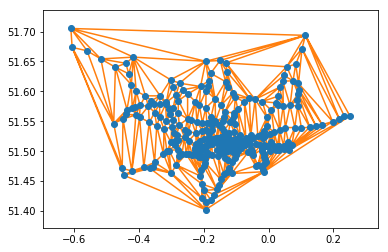

In [30]:
tri_stations = Delaunay(points)
_ = delaunay_plot_2d(tri_stations)
plt.show()

This could also get visualized through `matplotlib.triplot` as below:

Text(0, 0.5, 'Latitude')

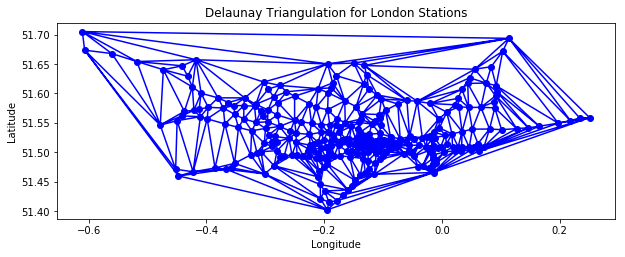

In [31]:
# Creating a Triangulation without specifying the triangles results in the
# Delaunay triangulation of the points.
x = stations['longitude']
y = stations['latitude']

# Create the Triangulation; no triangles so Delaunay triangulation created.
triang_stations = mpltri.Triangulation(x, y)

# Plot the triangulation.
plt.figure(figsize=(10,8))
plt.gca().set_aspect('equal')
plt.triplot(triang_stations, 'bo-') # define the color and shape
plt.title('Delaunay Triangulation for London Stations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

### <a id='Coplanar Points'>Coplanar Points<a/>

[Coplanar Points](https://study.com/academy/lesson/what-are-coplanar-points-definition-examples.html) are three or more points that lie in the same plane (the flat surface), which extends without end in all directions. It is usually shown in math textbooks as a four-sided figure. It could be also derived from the `Delaunay Triangulations` function in `Scipy.spatial` as below.

In [32]:
tri_stations.coplanar

array([], shape=(0, 3), dtype=int32)

The result should get an array with 3 numbers [$a$,$b$,$c$], but for our result it seems to be empty. Normally the first number $a$ is the index for point $a$, which is a duplicate/overlap point with others, and does not occur as a vertex of the triangulation $b$; and the third number $c$ is the nearest vertex for triangle $b$ to point $a$.

Now let us randomly pick up a station indexed with 10 for example, and do the following task:

In [33]:
i = 10
tri_stations.simplices[i,:] # the indices of the points that make up the triangle for point 10

array([238, 276, 275], dtype=int32)

In [34]:
points[tri_stations.simplices[i,:]] # coordinates of point 238, 276 and 275

array([[-0.4786, 51.5463],
       [-0.4733, 51.6404],
       [-0.5183, 51.6543]])

### <a id="Task 3">Task 3<a/>
1. Find the station names for above 3 points; **Hint**: recall your ability using index.
2. Get the information on neighboring triangles.

In [35]:
tri_stations.neighbors[10] # indices for neighboring triangles

array([ 12,  14, 300], dtype=int32)

In [36]:
points[tri_stations.neighbors[10,:]] # coordinates for the other points in the neighboring triangles

array([[-9.79000e-02,  5.15204e+01],
       [ 8.87000e-02,  5.15856e+01],
       [-3.27000e-02,  5.14767e+01]])

## <a id='Convex Hulls'>Convex Hulls<a/> (Optional)

As we are familiar with Convex hull (or Convex Envelope), it is the smallest convex object containing all points in a given point set $X$. Using our London stations data, let us compute convex hull via the [Qhull](http://www.qhull.org/) wrappers by either using a loop or calling the `convex_hall_plot_2d` method. Are they different significantly with each other?

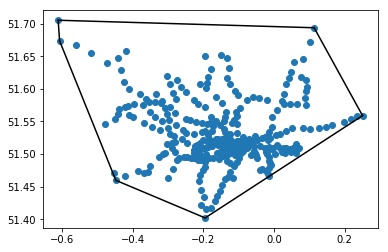

In [37]:
# use loop to plot convex hull
hull = ConvexHull(points)

plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
plt.show()

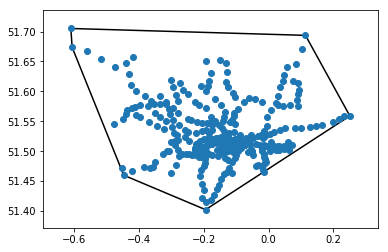

In [38]:
# use function to plot
_ = convex_hull_plot_2d(hull)
plt.show()

We could also have directly used the vertices of the hull, which for 2-D are guaranteed to be in counterclockwise order:

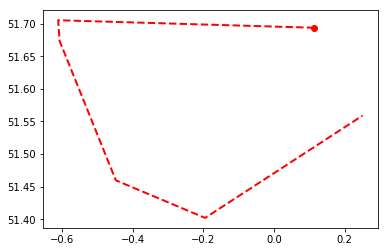

In [39]:
plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
plt.plot(points[hull.vertices[0],0], points[hull.vertices[0],1], 'ro')
plt.show()

### <a id="Task 4">Task 4<a/>
1. Save the stations .csv file into shapefile.
2. Read the shapefile into a geodataframe "stations_gdf".
3. Reproject the shapefile into EPSG 27700, preparing for the distance calculation.
    
**Hint**: two essential libraries haven't been imported, you need to it by yourself here.

We use Geopandas's GeodataFrame to define the essential elements for geospatial data, i.e. **CRS**. A coordinate reference system (CRS) determines how the 2D coordinates of the geometry objects should be related to actual places on the earth, see https://docs.qgis.org/2.8/en/docs/gentle_gis_introduction/coordinate_reference_systems.html for further information. The essential definition of geometry depends on data type, and normally for point data, we will call `shapely.geometry.Point` to set up.

In [40]:
# your code here
import shapely
import geopandas as gpd
# Set up geodataframe, initially with CRS = WGS84 (since that matches the lon and lat co-ordinates)
crs = {'init':'epsg:4326'}
# define the geometry of points with coordinates
geometry = [shapely.geometry.Point(xy) for xy in zip(stations['longitude'], stations['latitude'])]

stations_gdf = gpd.GeoDataFrame(stations, 
                          crs = crs, 
                          geometry = geometry)
# convert the .csv file into .shp file 
stations_gdf.to_file(driver='ESRI Shapefile', filename='data/stations.shp')

# reprojection 
stations_gdf.to_crs(epsg=27700)

,id,latitude,longitude,name,display_name,zone,total_lines,rail,geometry
0,1,51.5028,-0.2801,Acton Town,Acton<br />Town,3.0,2,0,POINT (519471.7767396716 179609.1939604392)
1,2,51.5143,-0.0755,Aldgate,NaN,1.0,2,0,POINT (533637.9301733428 181241.5310081635)
2,3,51.5154,-0.0726,Aldgate East,Aldgate<br />East,1.0,2,0,POINT (533835.9227378727 181369.1496011436)
3,4,51.5107,-0.0130,All Saints,All<br />Saints,2.0,1,0,POINT (537985.2982808145 180957.1002009927)
4,5,51.5407,-0.2997,Alperton,NaN,4.0,1,0,POINT (518013.5392242243 183792.121358341)
5,7,51.5322,-0.1058,Angel,NaN,1.0,1,0,POINT (531484.0536860223 183177.219004365)
6,8,51.5653,-0.1353,Archway,NaN,2.5,1,0,POINT (529344.1744840239 186805.5193276259)
7,9,51.6164,-0.1331,Arnos Grove,Arnos<br />Grove,4.0,1,0,POINT (529351.5315290231 192491.9808716626)
8,10,51.5586,-0.1059,Arsenal,NaN,2.0,1,0,POINT (531401.1000117685 186112.8184904589)
9,11,51.5226,-0.1571,Baker Street,Baker<br />Street,1.0,5,0,POINT (527952.9000390505 182018.7887955866)


## <a id='Interpolation'> [Interpolation](https://en.wikipedia.org/wiki/Multivariate_interpolation)</a> 

Interpolation is a method of constructing new data points within the range of a discrete set of known data points. There are various methods to realize interpolation, e.g. Piecewise constant interpolation, Linear interpolation, Polynomial interpolation, Spline interpolation, Inverse Distance Weighting interpolation etc. To be brief, we normally start with known values, and want to estimate the unknown points through interpolation.
It is straightforward to do so with `numpy`, `scipy.interpolate.griddata`, and `matplotlib`. However, we will not spend too much time on the normal interpolation functions this time, instead we will try to visualize a more sophisticated and widely utilized interpolation, kriging, by calling `pykrige` in this practical.

The basic rationale for `scipy`'s `griddata` interpolation is that:

$x$ and $y$ are locations of points, corresponding to longitude and latitude values of the stations; we need another $z$ value for the corresponding point, so we will read in a new dataset "annual station entry and exit figures" to measure the stations performances (by million, and compiled based on data from London Datastore).

The defined interpolation method will work out a way to mask the field, upon the user's defintion of a landmask on the grid, it will further try to calculate the result for the target grid axes. $x_i$ and $y_i$ are target grid axes, in another word, the target longitude and latitude coordinates, which must match the landmask field; whilst $z_i$ is the interpolated result for the point value. The methods argument to griddata could be various, either linear, cubic or nearest. 

Let's firstly join the 2 datasets together.

In [43]:
ee_stations=pd.read_csv('data/annual_station_entry_and_exit_figures.csv')
ee_stations.head()

,name,2017,2016,2015
0,Acton Town,6.04,6.27,6.24
1,Barbican,11.83,11.97,11.28
2,Aldgate,8.85,8.01,7.53
3,Aldgate East,14.00,13.43,12.84
4,Alperton,3.05,3.17,3.21


Because not all stations have values on entries&exits, so we need to 
### <a id="Task 5">Task 5<a/>
1. join these two datasets by station names;
2. delete those rows with NaN values;
3. only keep columns 'name', 'latitude', 'longitude', '2017', '2016' and '2015' for further interpolation operations.

In [44]:
# Your code here
sta_ee=ee_stations.join(stations.set_index('name'), on='name').dropna()
sta_ee.drop(columns=['id', 'zone','total_lines', 'rail', 'display_name'])

,name,2017,2016,2015,latitude,longitude,geometry
0,Acton Town,6.04,6.27,6.24,51.5028,-0.2801,POINT (-0.2801 51.5028)
3,Aldgate East,14.00,13.43,12.84,51.5154,-0.0726,POINT (-0.0726 51.5154)
8,Arnos Grove,4.61,4.65,4.55,51.6164,-0.1331,POINT (-0.1331 51.6164)
10,Baker Street,28.78,29.75,29.38,51.5226,-0.1571,POINT (-0.1571 51.5226)
15,Barons Court,7.12,7.21,7.30,51.4905,-0.2139,POINT (-0.2139 51.4905)
18,Belsize Park,6.24,6.48,6.16,51.5504,-0.1642,POINT (-0.1642 51.5504)
19,Bethnal Green,15.57,16.27,16.16,51.5270,-0.0549,POINT (-0.0549 51.527)
21,Blackhorse Road,9.00,8.45,8.36,51.5867,-0.0417,POINT (-0.0417 51.5867)
22,Bond Street,38.80,39.53,37.12,51.5142,-0.1494,POINT (-0.1494 51.5142)
24,Boston Manor,2.29,2.32,2.24,51.4956,-0.3250,POINT (-0.325 51.4956)


Text(0.5, 1.0, 'entries and exits in 2017')

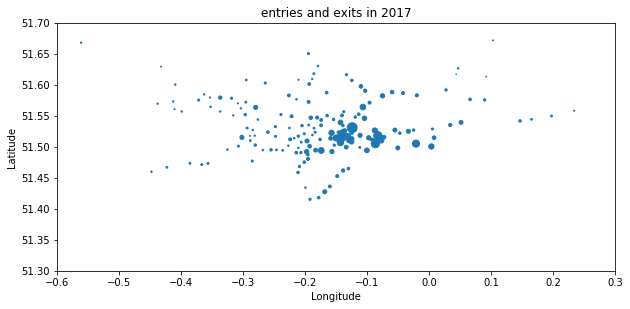

In [45]:
x=sta_ee['longitude']
y=sta_ee['latitude']
z=sta_ee['2017']
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(x,y,z, cmap='grey')
ax.set_aspect(1)
ax.set_xlim(-0.6,0.3)
ax.set_ylim(51.3,51.7)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('entries and exits in 2017')

### <a id='Basic Interpolation'>Basic Interpolation</a>
As we only get the entries & exits values for 166 stations, so how shall we estimate the entries & exits for other 52 stations specifically? For example, All Saints station at (51.5107, -0.013) and Blackwall station at (51.5079, -0.0066). We can use interpolation technique to realize it. Let's start from basic statistical interpolation: 

Text(0.5, 1.0, '')

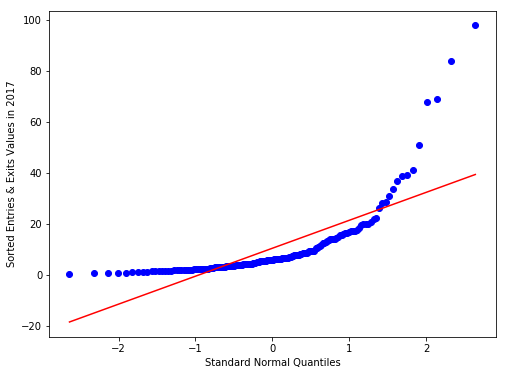

In [47]:
import scipy.stats as stats
qqdata = stats.probplot(z, dist="norm",plot=plt,fit=False)
fig=plt.gcf()
fig.set_size_inches(8,6)
plt.xlabel('Standard Normal Quantiles')
plt.ylabel('Sorted Entries & Exits Values in 2017')
plt.title('')

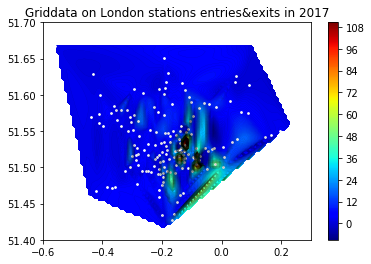

In [49]:
from scipy.interpolate import griddata
import numpy.ma as ma

lons=sta_ee['longitude']
lats=sta_ee['latitude']

# define grid with 0.009°longitude and 0.004°latitude steps.
xi = np.linspace(-0.6,0.3,100)
yi = np.linspace(51.3,51.7,100)
# grid the data, methods might be cubic, linear and nearest
zi = griddata((lons, lats), z, (xi[None,:], yi[:,None]), method='cubic') 
# contour the gridded data, plotting dots at the randomly spaced data points.
CS = plt.contour(xi,yi,zi,255,linewidths=0.05,colors='k')
CS = plt.contourf(xi,yi,zi,255,cmap=plt.cm.jet)
plt.colorbar() # draw colorbar
# plot data points.
plt.scatter(lons,lats,marker='o',c='w',s=3)
plt.xlim(-0.6,0.3)
plt.ylim(51.4,51.7)
plt.title('Griddata on London stations entries&exits in 2017')
plt.show()

### <a id='Kriging Interpolation'>[Kriging Interpolation](https://en.wikipedia.org/wiki/Kriging)</a> 
`Kriging` is a set of geostatistical techniques for interpolation, based on statistical models that include `spatial autocorrelation` (will be covered on week 8), or tendency of values of entities closer in space to be related. Differs from other interpolation techniques, Kriging honors those measurements at sampled locations, and instead sacrifices smoothness for the integrity of sampled points; so it can either provide an optimal continuous prediction surface or map of the phenomenon, or deliver a measure of confidence of how likely that prediction will be true. For example, if we want to interpolate the rainfall value for specific location in London, kriging can not only tell us how much the rainfall there, but also the probability of such volumn of rainfall. 

Kriging is widely used in the domain of spatial analysis and computer experiments, and is most appropriate when you know there is a spatially correlated distance or directional bias in the data. It is more predictive for probability rather than deterministic. Under suitable assumptions on the prior covariances, kriging gives the best linear unbiased prediction of the intermediate values using Gaussian process model: Z(s) = μ(s) + ε(s), where μ(s) is the deterministic component and ε(s) is the probabilistic component, and both are functions of distance. In order to predict the values at unmeasured locations, the weights were formed from surrounding measured values and their spatial structures, which was the crucial component for Kriging interpolation `semivariogram`. 

Semivariogram plots the difference in pair values (variance) against their distances, closer things are more related and have small semivariance (SV), while far things are less related and have a high semivariance (SV) until certain distance (range), reaching at a flattened value (sill) and the intercept (nugget), indicating no longer any spatial autocorrelation. Based on these results, we can further select a semivariogram that is spherical, circular, exponential, Gaussian or linear. 

Practically Kriging is a multistep process including exploratory statistical analysis of the data, variogram modeling, creating the surface, and exploring a variance surface. So we will, in the following, start with building a mathematical function with a `semivariogram`, then to create a prediction surface and finally validate the model with cross-validation.  

Let's start our visualization with simpler 1-dimensional Kriging interpolation for London station data. 

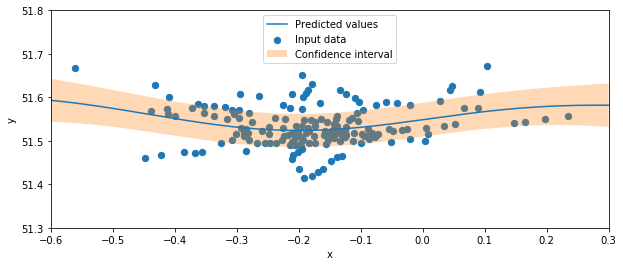

In [50]:
import os
X = np.asarray(lons).T
y = np.asarray(lats).T
X_pred = np.linspace(-0.6, 0.3, 300)
# pykrige doesn't support 1D data for now, only 2D or 3D
# adapting the 1D input to 2D
uk = OrdinaryKriging(X, np.zeros(X.shape), y, variogram_model='gaussian',)
y_pred, y_std = uk.execute('grid', X_pred, np.array([0.]))
y_pred = np.squeeze(y_pred)
y_std = np.squeeze(y_std)
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.scatter(X, y, s=40, label='Input data')
ax.plot(X_pred, y_pred, label='Predicted values')
ax.fill_between(X_pred, y_pred - 20*y_std, y_pred + 20*y_std, alpha=0.3, label='Confidence interval') 
# change the value of the confidence interval, any differences spotted?
ax.legend(loc=9) 
ax.set_xlabel('x') 
ax.set_ylabel('y') 
ax.set_xlim(-0.6, 0.3) 
ax.set_ylim(51.3, 51.8)
if 'CI' not in os.environ:
    # skip in continous integration
    plt.show()

#### <a id='2D Kriging Calculation'>2D Kriging Calculation</a> 
A brief idea about the predicative capability of Kriging interpolation could be derived from you work above, and now let's move further to 2-dimensional data.

#### Choose the Kriging Type
It is one of the essential criteria to choose types for kriging. As in widely used geographical appliciations, e.g. ArcGIS 10.x, the defaulted methods for kriging are either `Ordinary kriging` or `Simple Kriging`, we are going to practice with `Ordinary kriging`. However, it is better to have knowledge that, there are more complicated kriging types exist:
- Universal Kriging: combines trend surface analysis (drift) with ordinary kriging by accounting for trends
- Indicator Kriging: carries through ordinary kriging with binary data (0 and 1) such as urban and non-urban cells.
- Probablity Kriging: uses binary data (similar to indicator kriging) and estimates unknown points for a series of cutoffs.

**Semivariogram** is crucial to Kriging interpolation, with essential outputs for interpreting the Kriging interpolation calculation.

The semivariogram allows us to show the average variation for each pair of points, and is given by,
<img src="3.png" style="width: 200px;"/>

where $h$ is distance specified by the user, and $z_i$ and $z_j$ are two points that are separated spatially by h. The $N(h)$ term is the number of points we have that are separated by the distance h. The semivariogram then is the sum of squared differences between values separated by a distance $h$,
<img src="4.png" style="width: 200px;"/>


where $N$ is the number of data points, $\hat\mu$ is the sample mean, and $z_k$ is a data point. For sample variance, we are taking the squared difference between data points and the mean, and in the semivariogram we are taking the squared difference between data points separated by distance $h$, and the inverse is the covariance matrix which shows correlation over space. Based on the scatter of points, the computer fits a curve through those points with a slope where autocorrelation exists.
<img src="Variogram.png" style="width: 200px;"/>
**Sill**: The value at which the model first flattens out.

**Range**: The distance at which the model first flattens out.

**Nugget**: The value at which the semi-variogram (almost) intercepts the y-value.

We use the `ordinary kriging` function of `pykrige` package to interpolate our data at the defined grid points. For more details, the user can refer to the manual of the `pykrige` package.

In [51]:
# geometric ordinary kriging on a sphere
# Make this example reproducible:
np.random.seed(1234567)

N=166
lons=np.asarray(sta_ee['longitude']).T
lats=np.asarray(sta_ee['latitude']).T
z=np.asarray(sta_ee['2017']).T
# Generate a regular grid with 0.009°longitude and 0.004°latitude 100 steps:
# change the value of steps and spot out the differences of outputs:
grid_lons = np.linspace(-0.6, 0.3, 101)
grid_lats = np.linspace(51.3, 51.7, 101)
# Create ordinary kriging object:
OK = OrdinaryKriging(lons, lats, z, variogram_model='linear', verbose=False,
                     enable_plotting=False, coordinates_type='geographic')
# Execute on grid:
z1, ss1 = OK.execute('grid', grid_lons, grid_lats)

# Create ordinary kriging object ignoring curvature:
OK = OrdinaryKriging(lons, lats, z, variogram_model='linear', verbose=False,
                     enable_plotting=False)
# Execute on grid:
z2, ss2 = OK.execute('grid', grid_lons, grid_lats)
# Print data at equator (last longitude index will show periodicity):
print("Original data:") 
print("Longitude:",lons.astype(float))
print("Latitude: ",lats.astype(float))
print("z: ",z.astype(float)) 
print("\n======================\nKrige at\nLatitude:", grid_lats) 
print("Longitude:",grid_lons)
print("Value: ",np.array_str(z1[5,:], precision=2)) 
print("Sigma2: ",np.array_str(ss1[5,:], precision=2)) 
print("\nIgnoring curvature:\n=====================") 
print("Value: ",np.array_str(z2[5,:], precision=2)) 
print("Sigma2: ",np.array_str(ss2[5,:], precision=2))

Original data:
Longitude: [-0.2801 -0.0726 -0.1331 -0.1571 -0.2139 -0.1642 -0.0549 -0.0417 -0.1494
 -0.325  -0.1243 -0.0247 -0.2136  0.0471 -0.2641 -0.1188 -0.1426 -0.0904
 -0.2947 -0.561  -0.1538 -0.1111 -0.2678 -0.1384 -0.1299 -0.148  -0.1778
 -0.1243  0.1655  0.1469 -0.2387 -0.3017 -0.2882 -0.1973 -0.2474 -0.165
  0.0518 -0.2112 -0.1001  0.1977 -0.1359 -0.1932 -0.1803 -0.1065 -0.195
  0.0663 -0.1829 -0.1941 -0.2267 -0.1347  0.0923 -0.1439 -0.1428 -0.2933
 -0.3366 -0.2259 -0.1943 -0.104  -0.1925 -0.206  -0.1132 -0.3665 -0.3564
 -0.3855 -0.1527 -0.225  -0.2106 -0.1402 -0.285  -0.1939 -0.1238 -0.2107
 -0.1115 -0.1756 -0.2172 -0.1281 -0.0823 -0.0864 -0.1854 -0.0958 -0.094
 -0.1586 -0.0332 -0.2103 -0.432  -0.1387  0.0899 -0.2597 -0.2887 -0.3626
 -0.3034 -0.3184 -0.4092 -0.1967 -0.0873 -0.1415 -0.2841 -0.2011 -0.2954
 -0.2089 -0.2047 -0.2359 -0.3714 -0.1466  0.0439 -0.188  -0.4103 -0.4125
 -0.1244 -0.1335 -0.174  -0.0973 -0.0749 -0.1565 -0.3072 -0.3521 -0.1738
 -0.3081 -0.3988 -0.1919  0.

We can see that the interpolated value 10.54 dominates the kriged results, since it is the closest node in spherical distance metric, as longitude differences scale with cos(latitude). When kriging using longitude / latitude linearly, the value for grid points with longitude values further away, as longitude is now incorrectly weighted equally as latitude. So let's try to change the `variogram_model` method into `gaussian`, and see what's the difference. This time, we also further changed the values for minimum and maximum of the longitude and latitude based on the data.

Plotting Enabled

Initializing variogram model...
Coordinates type: 'geographic' 

Using 'gaussian' Variogram Model
Partial Sill: 109.74219009751945
Full Sill: 120.36523751279705
Range: 0.0005881477696680626
Nugget: 10.623047415277602 



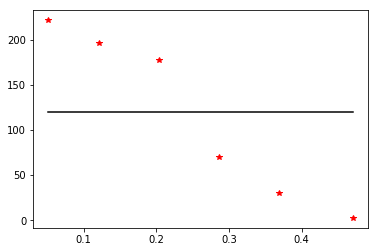

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



In [52]:
# change the variogram_model method into gaussian, results varied, optimal methods
grid_lon = np.arange(lons.min()-0.001, lons.max()+0.001, 200) # define the grid points for interpolated values.
grid_lat = np.arange(lats.min()-0.001, lats.max()+0.001, 200)

# Creates the kriged grid and the variance grid. Allows for kriging on a rectangular 
OK = OrdinaryKriging(lons, lats, z, variogram_model='gaussian', verbose=True, enable_plotting=True, coordinates_type='geographic')
# grid of points, on a masked rectangular grid of points, or with arbitrary points. 
z1, ss1 = OK.execute('grid', grid_lon, grid_lat)

As we only have 166 stations joined, and want to predict the entry & exit figure for other excluded stations, e.g. All Saints station at (51.5107, -0.013) and Blackwall station at (51.5079, -0.0066), so we can use `Ordinary Kriging` to interpolate the missing data.

In [53]:
ztest, sstest = OK.execute('grid', [-0.013, -0.00066], [51.5107, 51.5079])
print(ztest)

Executing Ordinary Kriging...

[[10.54499999999602 10.54499999999602]
 [10.54499999999602 10.54499999999602]]


#### <a id='2D Kriging Visualization'>2D Kriging Visualization</a> 
To get interpolation results plotted will be more straightforward, but we should be careful about the geographical data's CRS when conducting any spatial analysis.

In [54]:
# save sta_ee into shapefile
crs={'init': 'epsg:4326'}
# define the geometry of points with coordinates
geometry = [shapely.geometry.Point(xy) for xy in zip(sta_ee['longitude'], sta_ee['latitude'])]

data_df = gpd.GeoDataFrame(sta_ee, 
                          crs = crs, 
                          geometry = geometry)
# convert the .csv file into .shp file 
data_df.to_file(driver='ESRI Shapefile', filename='data/sta_ee.shp')

### <a id="Task 6">Task 6<a/>
Get London stations plotted with `folium` below, and we will try to compare it with the kriging interpolation plot at the end.

In [55]:
# call the original dataframe
# plot latitude and longitude with WGS84 on folium
data_lat_long=gpd.read_file('data/sta_ee.shp')
data_lat_long['long'] = data_lat_long.geometry.apply(lambda x: x.x)
data_lat_long['lat'] = data_lat_long.geometry.apply(lambda x: x.y)
mean_long = np.mean(data_lat_long['long'])
mean_lat = np.mean(data_lat_long['lat'])
m = folium.Map([mean_lat, mean_long], zoom_start=10, tiles='Stamen Toner')

scale = cm.linear.YlGn_06.scale(vmin=0, vmax=data_lat_long['2017'].max())
for row in data_lat_long.iterrows():
    folium.CircleMarker(location=[row[1]['lat'], row[1]['long']], radius=10, color=None, fill_opacity=0.7,
                    fill_color=scale(row[1]['2017'])).add_to(m)
m.add_children(scale)

Be careful now! We have the "data_lat_long" dataframe with WGS84 coordinates, this will be used for interactive map visualization using `folium`, and will only be used at the end of this practical hereafter. However, since now we need to use another dataframe "staee" with OSBG 1936 (EPSG 27700) for following operations, why bother to do so? Try to discuss the reasons with your neighbors. **Hint**: recall your memory of point distances. 

In [56]:
staee=data_df.to_crs({'init': 'epsg:27700'})# change the crs into OSGB36 for further distance measurement
staee['longitude'] = staee['geometry'].apply(lambda x: x.x)
staee['latitude'] = staee['geometry'].apply(lambda x: x.y)

#### 1. Split the data into test and train

The process is similar to what we did with K Nearest Neighbors Classification, we set the dataset into train set and test set, to evaluate the interpolation results. As the basic rationale is distance-based, we need to use EPSG 27700 for calculation.

In [57]:
np.random.seed(9999999) # Control the random split with setting a seed so the results are reproducable
test_indexes = np.random.choice(a=staee.index, size=int(np.round(len(staee.index.values)/4)))
train_indexes = [index for index in staee.index if index not in test_indexes]
staee_test = staee.loc[test_indexes,:].copy()
staee_train = staee.loc[train_indexes,:].copy()
print('Number of observations in training: {}, in test: {}'.format(len(staee_train), len(staee_test)))

Number of observations in training: 131, in test: 42


#### 2. Ordinary kriging

Variogram parameters are set with trail and error.

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 150
Full Sill: 200
Range: 10000
Nugget: 50 



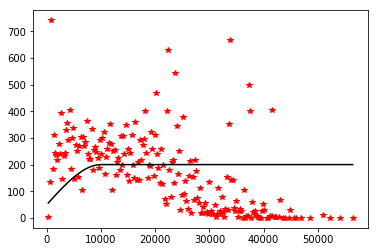

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...

Executing Ordinary Kriging...



In [58]:
# choose the sill，range and nugget by variogram_parameters configuration
model = OrdinaryKriging(x=staee_train['longitude'], y=staee_train['latitude'], z=staee_train['2017'], verbose=True,
                variogram_parameters=[200, 10000, 50],
                enable_plotting=True, nlags=250, weight=True, variogram_model='spherical')
staee_train['prediction'] = model.execute(style='points',xpoints=staee_train['longitude'], ypoints=staee_train['latitude'])[0].data
staee_train['kriging_residual'] = staee_train['2017'] - staee_train['prediction']
staee_test['prediction'] = model.execute(style='points', xpoints=staee_test['longitude'], ypoints=staee_test['latitude'])[0].data
staee_test['kriging_residual'] = staee_test['2017'] - staee_test['prediction']

#### Model performance (Optional)

We can test the model performance by plotting out some measures on:
- Performance on training data (kriging is an exact interpollator, so perfect prediction)
- Performance on test data

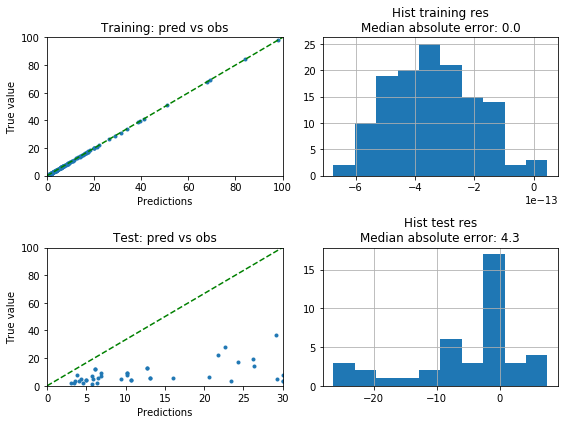

In [59]:
plt.figure(figsize=(8,6))
plt.subplot(221)
plt.plot(staee_train['prediction'], staee_train['2017'], '.')
plt.title('Training: pred vs obs')
plt.xlabel('Predictions')
plt.ylabel('True value')
plt.plot([0,100], [0,100], 'g--')
plt.ylim(0,100)
plt.xlim(0,100)

plt.subplot(222)
staee_train['kriging_residual'].hist()
plt.title('Hist training res\nMedian absolute error: {:.1f}'.format(np.median(np.abs(staee_train['kriging_residual']))))

plt.subplot(223)
plt.plot(staee_test['prediction'], staee_test['2017'], '.')
plt.plot([0,30], [0,100], 'g--')
plt.title('Test: pred vs obs')
plt.xlabel('Predictions')
plt.ylabel('True value')
plt.ylim(0,100)
plt.xlim(0,30)

plt.subplot(224)
staee_test['kriging_residual'].hist()
plt.title('Hist test res\nMedian absolute error: {:.1f}'.format(np.median(np.abs(staee_test['kriging_residual']))))
plt.tight_layout()

#### 3. Sample grids
The training data are sampled from the plotted grids, which are polygon, this is quite similar idea to what we did at the begining, `Voronoi`; so if we want to know how the grids been drawn, and how the points have been sampled from the grid polygon, we need to recall the concept of `convex hull` around the measurement, the method of `buffering` just introduced, and get the functions to sample a grid from a polygon. Although I list the functions below, but you can further read the [help document](http://portolan.leaffan.net/creating-sample-points-with-ogr-and-shapely-pt-2-regular-grid-sampling/).

In [60]:
class PolygonPointSampler(object):
 
    def __init__(self, polygon=''):
        u"""
        Initialize a new PolygonPointSampler object using the specified polygon
        object (as allocated by Shapely). If no polygon is given a new empty
        one is created and set as the base polygon.
        """
        if polygon:
            self.polygon = polygon
        else:
            self.polygon = Polygon()
        self.samples = list()
        self.sample_count = 0
        self.prepared = False
 
    def add_polygon(self, polygon):
        u"""
        Add another polygon entity to the base polygon by geometrically unifying
        it with the current one.
        """
        self.polygon = self.polygon.union(polygon)
        self.prepared = False
    
    def get_spatial_df(self):
        geo_df = pd.DataFrame(self.samples, columns=['geometry']).set_geometry('geometry')
        geo_df['x'] = geo_df['geometry'].apply(lambda x: x.coords[0][0])
        geo_df['y'] = geo_df['geometry'].apply(lambda x: x.coords[0][1])
        return geo_df
 
    def print_samples(self):
        u"""
        Print all sample points using their WKT representation.
        """
        for sample_pt in self.samples:
            print(sample_pt)
 
    def prepare_sampling(self):
        u"""
        Prepare the actual sampling procedure by splitting up the specified base
        polygon (that may consist of multiple simple polygons) and appending its
        compartments to a dedicated list.
        """
        self.src = list()
        if hasattr(self.polygon, 'geoms'):
            for py in self.polygon:
                self.src.append(py)
        else:
            self.src.append(self.polygon)
        self.prepared = True
 
    def perform_sampling(self):
        u"""
        Create a stub for the actual sampling procedure.
        """
        raise NotImplementedError
    
class RegularGridSampler(PolygonPointSampler):
    def __init__(self, polygon = '', x_interval = 100, y_interval = 100):
        super(self.__class__, self).__init__(polygon)
        self.x_interval = x_interval
        self.y_interval = y_interval
    
    def perform_sampling(self):
        u"""
        Perform sampling by substituting the polygon with a regular grid of
        sample points within it. The distance between the sample points is
        given by x_interval and y_interval.
        """
        if not self.prepared:
            self.prepare_sampling()
        ll = self.polygon.bounds[:2]
        ur = self.polygon.bounds[2:]
        low_x = int(ll[0]) / self.x_interval * self.x_interval
        upp_x = int(ur[0]) / self.x_interval * self.x_interval + self.x_interval
        low_y = int(ll[1]) / self.y_interval * self.y_interval
        upp_y = int(ur[1]) / self.y_interval * self.y_interval + self.y_interval
        
        for x in floatrange(low_x, upp_x, self.x_interval):
            for y in floatrange(low_y, upp_y, self.y_interval):
                p = shapely.geometry.Point(x, y)
                if p.within(self.polygon):
                    self.samples.append(p)

def floatrange(start, stop, step):
    while start < stop:
        yield start
        start += step

Text(0.5, 1.0, 'Sampled grid')

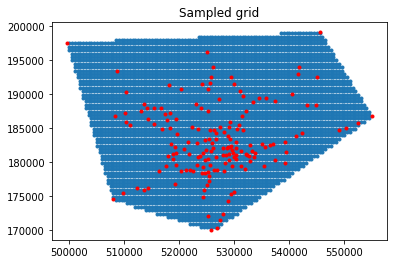

In [61]:
convex_hull = shapely.geometry.MultiPoint(list(staee.geometry)).convex_hull.buffer(100)
sampler = RegularGridSampler(convex_hull, x_interval=500, y_interval=500) # what is the unit of value 500?
sampler.perform_sampling()
grid_points = sampler.get_spatial_df()
plt.figure(figsize=(6,4))
plt.plot(grid_points['x'], grid_points['y'], '.')
plt.plot(staee['longitude'], staee['latitude'], 'r.')
plt.title('Sampled grid')

Are the grids making up a "fishnet" now? The next step is to krige a value for each grid point.
#### 4. Krige values for grid points

In [62]:
grid_points['prediction'] = model.execute(style='points', xpoints=grid_points['x'], ypoints=grid_points['y'])[0].data

Executing Ordinary Kriging...



The kriged values still can't be visible so far, as we need to be careful of CRS (!repeat reminder!). So before we really get to the step of plotting the kriging interpolation, we need to 
- Transform to lat long projection
- From long to wide format
- Fill in missing values

In [63]:
grid_points_gpd = grid_points.set_geometry('geometry')
grid_points_gpd.crs = {'init':'epsg:27700'}
grid_points_gpd = grid_points_gpd.to_crs({'init': 'epsg:4326'})
grid_points_gpd['longitude'] = grid_points_gpd.geometry.apply(lambda x: x.x)
grid_points_gpd['latitude'] = grid_points_gpd.geometry.apply(lambda x: x.y)

In [64]:
grid_points_pivot = grid_points_gpd.pivot(values='prediction', columns='x', index='y').fillna(0)
grid_points_pivot = grid_points_pivot.loc[:,grid_points_pivot.columns.sort_values(ascending=True)]
grid_points_pivot = grid_points_pivot.loc[grid_points_pivot.index.sort_values(ascending=True),:]

Finally, it is ready to enjoy the final "show".
#### Interpolation visualization

Text(0.5, 1.0, 'Kriged grid values')

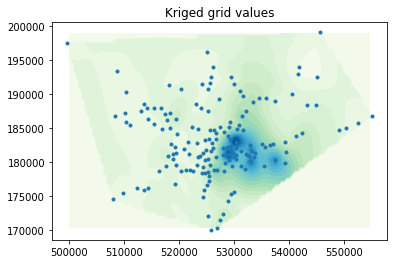

In [65]:
plt.contourf(np.unique(grid_points_pivot.columns.values), np.unique(grid_points_pivot.index.values), 
             grid_points_pivot.values/np.nanmax(grid_points_pivot.values),20,cmap='GnBu')
plt.plot(staee['longitude'], staee['latitude'], '.')
plt.title('Kriged grid values')

Although `matplotlib.pyplot` can help visualize the result, but still not good enough. Because we want to compare the differences from original map, and get the interpolated results shown with `folium` as well, so we can do the final task as: 

In [66]:
def color_function(value):
    if (value==0) | (value==np.nan) : return (0,0,0,0)
    else: 
        color = mpl.cm.YlOrRd(value) 
        return color

### <a id="Task 7">Task 7<a/>

In [67]:
from folium import raster_layers
m = folium.Map([mean_lat, mean_long], zoom_start=13, tiles='Stamen Toner')
m.add_children(raster_layers.ImageOverlay(image = (grid_points_pivot.values/np.nanmax(grid_points_pivot.values)), 
                                    bounds = [[np.min(grid_points_gpd['latitude']), np.min(grid_points_gpd['longitude'])],
                                            [np.max(grid_points_gpd['latitude']), np.max(grid_points_gpd['longitude'])]], 
                                    opacity=0.7,origin='lower', colormap=color_function))
for row in data_lat_long.iterrows():
    folium.CircleMarker(location=[row[1]['lat'], row[1]['long']], radius=20, color=None, fill_opacity=0.7,
                    fill_color=scale(row[1]['2017'])).add_to(m)
m.add_children(scale)

# Credits!